In [3]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble,\
                    neural_network, svm, decomposition, manifold
from rulefit import RuleFit
import statsmodels.api as sm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
import matplotlib.pyplot as plt
import seaborn as sns

2024-01-16 22:43:19.959466: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-16 22:43:19.959482: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [40]:
import sys
#Next two lines of code only needed while CVAE
import torch 
#remains incompatible to Tensorflow 2.2+
# import tensorflow.compat.v1 as tf
# sys.modules['tensorflow'] = tf
from cvae import cvae
#Next two lines of code only needed while SkopedRules
#remains incompatible to Sklearn 0.23.0+
import six
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

In [7]:
aad18_df = mldatasets.load("aa-domestic-delays-2018")

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip downloaded to /home/studio/바탕화면/ml/AA-OTP/data/aa-domestic-delays-2018.csv.zip
/home/studio/바탕화면/ml/AA-OTP/data/aa-domestic-delays-2018.csv.zip uncompressed to /home/studio/바탕화면/ml/AA-OTP/data/aa-domestic-delays-2018.csv
1 dataset files found in /home/studio/바탕화면/ml/AA-OTP/data/aa-domestic-delays-2018.csv folder
parsing /home/studio/바탕화면/ml/AA-OTP/data/aa-domestic-delays-2018.csv/aa-domestic-delays-2018.csv


In [8]:

aad18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DEP_TIME          899527 non-null  int64  
 5   DEP_TIME              899527 non-null  float64
 6   DEP_DELAY             899527 non-null  float64
 7   DEP_AFPH              899527 non-null  float64
 8   DEP_RFPH              899527 non-null  float64
 9   TAXI_OUT              899527 non-null  float64
 10  WHEELS_OFF            899527 non-null  float64
 11  CRS_ELAPSED_TIME      899527 non-null  float64
 12  PCT_ELAPSED_TIME      899527 non-null  float64
 13  DISTANCE              899527 non-null  float64
 14  CRS_ARR_TIME          899527 non-null  int64  
 15  

In [9]:
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])

In [10]:
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek

In [11]:
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

In [12]:
#Create list with 10 hubs
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']
#Boolean series for if ORIGIN or DEST are hubs
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)
#Use boolean series to set ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1
#Delete columns with codes
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

In [13]:
aad18_df.loc[aad18_df['ARR_DELAY'] > 15, ['ARR_DELAY','CARRIER_DELAY']].head(10)

,ARR_DELAY,CARRIER_DELAY
8,168.0,136.0
16,20.0,5.0
18,242.0,242.0
19,62.0,62.0
22,19.0,19.0
26,26.0,0.0
29,77.0,77.0
32,19.0,19.0
33,18.0,1.0
40,36.0,16.0


In [14]:
aad18_df = aad18_df.drop(['ARR_DELAY'], axis=1)

In [15]:
rand = 9
y = aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

In [16]:
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
ORIGIN_HUB             0.015334
DEST_HUB               0.013932
DISTANCE               0.010680
DEP_MONTH              0.009728
CRS_ELAPSED_TIME       0.008801
DEP_DOW                0.007043
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
SECURITY_DELAY         0.000460
Name: CARRIER_DELAY, dtype: float64

In [17]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()}, 
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
        #Trees  
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #RuleFit
        'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)}, 
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)}, 
        #Neural Networks
        'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500, 
                                                   early_stopping=True, random_state=rand)}
    }

In [18]:
for model_name in reg_models.keys():
    if model_name != 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
    else:
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

In [19]:
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
mlp,3.243516,3.308597,0.987025
random_forest,5.143267,6.088249,0.956065
linear_poly,6.213987,6.339854,0.952359
linear_interact,6.454305,6.562285,0.948957
decision_tree,6.542924,7.456335,0.934102
linear,7.819643,7.882875,0.926347
ridge,7.825425,7.887723,0.926256
knn,7.360098,9.259422,0.898377
rulefit,9.171496,9.308909,0.897288


In [28]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression(solver='liblinear')}, 
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},  
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7)}, 
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11,\
                                                                 class_weight='balanced', random_state=rand)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

In [29]:
print(y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0])

0.061283264255549


In [30]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train_class)
    y_train_pred = fitted_model.predict(X_train.values)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test.values) 
    else:
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = 0
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

In [31]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
mlp,0.998482,0.998555,0.987131,0.988865,0.999877,0.988207,0.987437
gradient_boosting,0.991725,0.991662,0.892930,0.893851,0.998885,0.929223,0.925619
random_forest,0.941840,0.940680,0.999445,0.992617,0.995074,0.672048,0.686955
decision_tree,0.983297,0.982895,0.856969,0.852215,0.994932,0.859182,0.850110
logistic,0.978720,0.978611,0.742408,0.742072,0.972864,0.809480,0.801967
knn,0.972886,0.965123,0.680645,0.607722,0.948387,0.680906,0.668176
naive_bayes,0.925119,0.925539,0.279126,0.274268,0.811869,0.310858,0.274984
ridge,0.890493,0.891240,0.776853,0.778383,0.000000,0.467081,0.463847


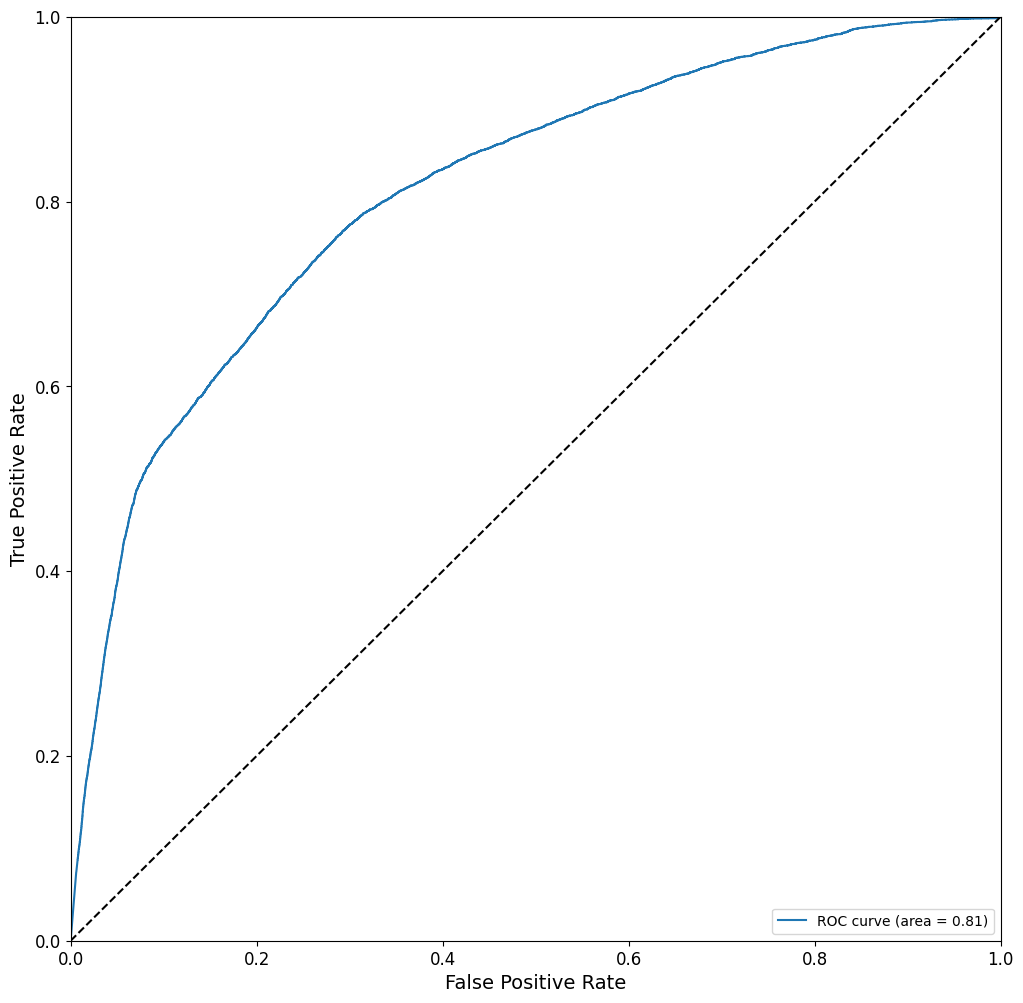

In [32]:
plt.figure(figsize = (12,12))
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
fpr, tpr, _ = metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [43]:
X_train_abbrev = X_train.iloc[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
X_test_abbrev = X_test.iloc[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(X_test.shape[0],\
                              math.ceil(X_test.shape[0]*sample_size), replace=False)

dimred_methods = {
        #Decomposition
        'pca':{'method': decomposition.PCA(n_components=3, random_state=rand)},  
        #Manifold Learning
        't-sne':{'method': manifold.TSNE(n_components=3, random_state=rand)},
        #Variational Autoencoders
        'vae':{'method': cvae.CompressionVAE(X_train_abbrev.values,\
                                             dim_latent=3, tb_logging=False)}, 
    }

Total amount of data:  688137
Input feature dimension:  9
Calculating normalisation factors.
Normalisation factors calculated.


AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [37]:
import tensorflow.compat.v1 as tf
sys.modules['tensorflow'] = tf

ImportError: cannot import name 'v1' from 'tensorflow.compat.v1.compat.v1.compat' (/home/studio/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/_api/v2/compat/v1/compat/v1/compat/__init__.py)

In [41]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

ImportError: cannot import name 'v1' from 'tensorflow.compat.v1.compat.v1.compat' (/home/studio/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/_api/v2/compat/v1/compat/v1/compat/__init__.py)

In [46]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

x = tf.placeholder(shape=[None, 2], dtype=tf.float32)

ImportError: cannot import name 'v1' from 'tensorflow.compat.v1.compat.v1.compat' (/home/studio/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/_api/v2/compat/v1/compat/v1/compat/__init__.py)